Train on full dataset. Forget overfitting!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib

from common import loss_utils

import sys
sys.path.append('./dgmr-multichannel')
import dgmr

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16
FOLDER = 'dgmr_coordconv'

In [5]:
p = pathlib.Path('data/train.npz')
f = np.load(p)
times = f['times']
data = f['data']

p = pathlib.Path('data/test.npz')
f = np.load(p)
times2 = f['times']
data2 = f['data']

times = np.concatenate([times, times2], axis=0)
data = np.concatenate([data, data2], axis=0)

p = pathlib.Path('data/coords.npz')
f = np.load(p)
x_osgb = f['x_osgb']
y_osgb = f['y_osgb']

In [6]:
times.shape, data.shape, x_osgb.shape, y_osgb.shape

((44085,), (44085, 325, 400), (325, 400), (325, 400))

In [7]:
_MEAN_PIXEL = 240.3414
_STD_PIXEL = 146.52366

_MEAN_X_OSGB = x_osgb.mean()
_STD_X_OSGB = x_osgb.std()

_MEAN_Y_OSGB = y_osgb.mean()
_STD_Y_OSGB = y_osgb.std()

In [8]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, x_osgb, y_osgb, random_state=7):
        self.times = times
        self.data = data
        self.x_osgb = x_osgb
        self.y_osgb = y_osgb
        self.generator = np.random.RandomState(random_state)
        
        
    def _get_crop(self, data):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, data.shape[2] - 128)
        rand_y = self.generator.randint(0, data.shape[1] - 128)
        # make a data selection
        return (
            data[:, rand_y : rand_y + 128, rand_x : rand_x + 128],
            self.x_osgb[rand_y : rand_y + 128, rand_x : rand_x + 128],
            self.y_osgb[rand_y : rand_y + 128, rand_x : rand_x + 128],
        )

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        all_data = self.data[index:index+INPUT_STEPS+24]
        all_data, crop_x_osgb, crop_y_osgb = self._get_crop(all_data)
        all_data = (all_data - _MEAN_PIXEL) / _STD_PIXEL
        crop_x_osgb = (crop_x_osgb - _MEAN_X_OSGB) / _STD_X_OSGB
        crop_y_osgb = (crop_y_osgb - _MEAN_Y_OSGB) / _STD_Y_OSGB
        all_data = torch.FloatTensor(all_data)
        crop_x_osgb = torch.FloatTensor(crop_x_osgb)
        crop_y_osgb = torch.FloatTensor(crop_y_osgb)
        x = all_data[:INPUT_STEPS]
        y = all_data[INPUT_STEPS:]
        
        # adds a satellite dimension
        x = torch.unsqueeze(x, axis=1)
        y = torch.unsqueeze(y, axis=1)
        
        # expand these for concatenation with x
        crop_x_osgb = torch.tile(crop_x_osgb, (INPUT_STEPS, 1, 1, 1))
        crop_y_osgb = torch.tile(crop_y_osgb, (INPUT_STEPS, 1, 1, 1))
        
        # concatenate with x
        x = torch.cat([x, crop_x_osgb, crop_y_osgb], dim=1)
        
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data, x_osgb, y_osgb)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [9]:
x, y = ds[0]

In [10]:
x.shape, y.shape

(torch.Size([4, 3, 128, 128]), torch.Size([24, 1, 128, 128]))

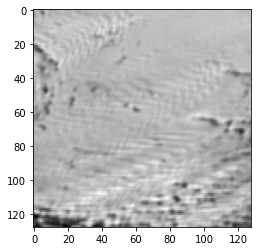

In [11]:
plt.imshow(x[-1,0], cmap='gray')

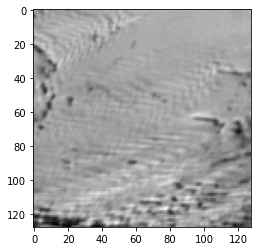

In [13]:
plt.imshow(y[0,0], cmap='gray')

In [14]:
ccs = dgmr.common.ContextConditioningStack(
    input_channels=3,
    conv_type='standard',
    output_channels=192,
)

lcs = dgmr.common.LatentConditioningStack(
    shape=(8 * 1, 128 // 32, 128 // 32),
    output_channels=192,
)

_input_channels_mult = 2
sampler = dgmr.generators.Sampler(
    forecast_steps=FORECAST,
    latent_channels=192,
    context_channels=192*_input_channels_mult,
    output_channels=1,
)

model = dgmr.generators.Generator(ccs, lcs, sampler)
model = model.to(DEVICE)

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 14493181 trainable parameters


In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
msssim_criterion = loss_utils.MS_SSIMLoss(1023.0, channels=24)

In [19]:
def train_epoch(model, epoch, dl, optimizer, criterion):
    model.train()

    epoch_loss = 0
    total_count = 0
    optimizer.zero_grad()
    pbar = tqdm.tqdm(dl)
    for i, (srcs, trgs) in enumerate(pbar):
        x = srcs.to(DEVICE)
        y = trgs.to(DEVICE)
        preds = model(x)
        y = y * _STD_PIXEL + _MEAN_PIXEL
        preds = preds * _STD_PIXEL + _MEAN_PIXEL
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ls = loss.item()
        epoch_loss += ls
        total_count += 1
        if i % 1 == 0:
            ls = round(ls, 4)
            avg_loss = round(epoch_loss / total_count, 4)
            pbar.set_description(f'Avg Loss, Batch Loss: {avg_loss, ls}')
            if i % 300 == 299:
                torch.save(model.state_dict(), f'weights/{FOLDER}/dgmr_epochs={epoch}_batch={i}_loss={avg_loss}.pt')
    return epoch_loss / total_count




In [20]:
EPOCHS = 100
EXISTING = 0

for i in range(EXISTING + 1, EPOCHS + 1):
    print(f"Epoch {i}")
    avg_loss = train_epoch(model, i, dl, optimizer, msssim_criterion)
    avg_loss = round(avg_loss, 4)
    torch.save(model.state_dict(), f'weights/{FOLDER}/dgmr_epochs={i}_loss={avg_loss}.pt')


Epoch 1


Avg Loss, Batch Loss: (0.2753, 0.1221): 100%|██████████| 2754/2754 [32:40<00:00,  1.40it/s]


Epoch 2


Avg Loss, Batch Loss: (0.2543, 0.3485): 100%|██████████| 2754/2754 [32:58<00:00,  1.39it/s]


Epoch 3


Avg Loss, Batch Loss: (0.2475, 0.2061): 100%|██████████| 2754/2754 [32:59<00:00,  1.39it/s]


Epoch 4


Avg Loss, Batch Loss: (0.2446, 0.2184): 100%|██████████| 2754/2754 [32:58<00:00,  1.39it/s]


Epoch 5


Avg Loss, Batch Loss: (0.2427, 0.1682): 100%|██████████| 2754/2754 [33:02<00:00,  1.39it/s]


Epoch 6


Avg Loss, Batch Loss: (0.2413, 0.1435): 100%|██████████| 2754/2754 [33:00<00:00,  1.39it/s]


Epoch 7


Avg Loss, Batch Loss: (0.2398, 0.2668): 100%|██████████| 2754/2754 [33:01<00:00,  1.39it/s]


Epoch 8


Avg Loss, Batch Loss: (0.2392, 0.2074): 100%|██████████| 2754/2754 [33:03<00:00,  1.39it/s]


Epoch 9


Avg Loss, Batch Loss: (0.2383, 0.3691): 100%|██████████| 2754/2754 [33:01<00:00,  1.39it/s]


Epoch 10


Avg Loss, Batch Loss: (0.2374, 0.1878):  48%|████▊     | 1316/2754 [15:49<17:17,  1.39it/s]


KeyboardInterrupt: 

In [20]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        scores = []
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)
        for i in range(y.shape[1]):
            score = criterion(y[:,i:i+1], x[:,i:i+1])
            scores.append(score.item())
        return scores

In [19]:
LOOKS = int(5000/BATCH_SIZE)

In [21]:
model.train()
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl, total=LOOKS)
for i, (srcs, trgs) in enumerate(pbar):
    if i > LOOKS:
        break
    x = srcs.to(DEVICE)
    y = trgs.to(DEVICE)
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    
    preds = []
    for _ in range(1):
        with torch.no_grad():
            p = model(x)
            preds.append(p)
    preds = torch.mean(torch.stack(preds, dim=0), dim=0)
    
    y = y * _STD_PIXEL + _MEAN_PIXEL
    preds = preds * _STD_PIXEL + _MEAN_PIXEL
    score = get_mssim(preds, y, average=False)
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')

    

  0%|          | 0/312 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Avg Score: 0.7807311997991905: : 313it [02:02,  2.56it/s]                       


In [22]:
scores = np.array(scores)
scores.mean()

0.7807311997991908

In [23]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.95559188, 0.92036054, 0.88966255, 0.86269325, 0.83943689,
       0.81971426, 0.80351024, 0.79000379, 0.77848016, 0.76899063,
       0.76120276, 0.75483571, 0.74961491, 0.74526883, 0.74171417,
       0.73855603, 0.73569226, 0.7330805 , 0.73069161, 0.72824245,
       0.72587696, 0.72360827, 0.7213976 , 0.71932255])

In [28]:
out = preds.detach().cpu().numpy()
true = y.detach().cpu().numpy()

out = np.squeeze(out)
true = np.squeeze(true)

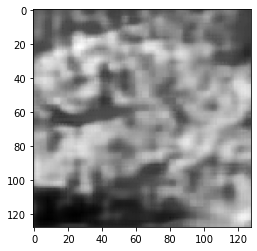

In [29]:
plt.imshow(out[0,0], cmap='gray')

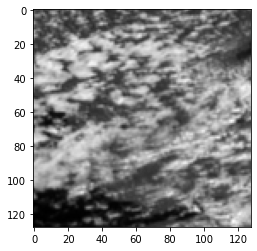

In [30]:
plt.imshow(true[0,0], cmap='gray')

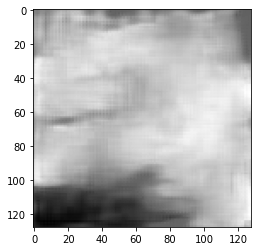

In [31]:
plt.imshow(out[0,-1], cmap='gray')

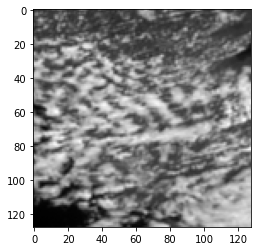

In [32]:
plt.imshow(true[0,-1], cmap='gray')